In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%%capture
!pip install laspy
!pip install rasterio
!pip install alphashape shapely
!pip install open3d

In [ ]:
import glob

import tqdm
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.stats
import seaborn as sns
import shapely
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import laspy
import scipy.stats

In [ ]:
file_paths = glob.glob("/kaggle/input/hutechaichallenge2024-mc/Train/*/*.las")
file_paths.sort()

In [ ]:
data = pd.DataFrame({"path": file_paths})
data["species"] = data["path"].map(lambda p: p.split("/")[-2])
data.sample(n=3)

# Computing features

In [ ]:
# Step 1: Find the highest tree (Ptop)
def find_highest_tree(points):
    idx = np.argmax(points[:, 2])  # Find point with max Z
    return points[idx]

# Step 2: Rotate profile and extract edge points
def extract_tree_edges(points, Ptop, num_segments=36):
    angles = np.linspace(0, np.pi, num_segments)  # Rotate from 0° to 180°
    edge_points = []
    
    for angle in angles:
        # Rotate points around Ptop
        rot_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        rotated_xy = (points[:, :2] - Ptop[:2]) @ rot_matrix.T + Ptop[:2]
        rotated_points = np.column_stack((rotated_xy, points[:, 2]))
        
        # Find the convex hull
        hull = ConvexHull(rotated_points[:, :2])
        edge_points.append(rotated_points[hull.vertices])
    
    return edge_points

# Step 3: Cluster trees based on extracted edges
def segment_trees(points, edge_points, threshold=1.0):  # Giảm threshold để phân cụm tốt hơn
    clustered = np.zeros(len(points), dtype=int)
    cluster_id = 1
    
    for edges in edge_points:
        for edge in edges:
            distances = np.linalg.norm(points[:, :2] - edge[:2], axis=1)
            clustered[distances < threshold] = cluster_id
        cluster_id += 1
    return clustered.tolist()

In [ ]:
def extract_tree_crown_keypoints(points, tree_top, dis):
    """
    Extract keypoints of the tree crown based on the steps provided.

    Args:
        points (numpy.ndarray): Array of points (N, 3) representing the point cloud.
        tree_top (tuple): (x, y, z) coordinates of the tree top vertex.
        dis (float): Average point spacing distance.

    Returns:
        numpy.ndarray: Keypoints of the tree crown.
    """
    # 1. Draw the vertical line L from the tree top to the ground
    x_top, y_top, z_top = tree_top
    z_min = np.min(points[:, 2])  # Ground level (minimum Z value)
    
    # 2. Calculate the width D
    D = 2 * dis  # Width of the profile around the tree top
    
    # 3. Draw parallel lines with spacing d
    d = dis  # Can use the same value for spacing
    keypoints = []

    # Iterate through several levels from tree top to ground
    num_lines = int((z_top - z_min) / d)  # Number of lines along the Z-axis
    for i in range(num_lines):
        z_level = z_top - i * d  # Current level of the parallel line
        # Find points around the current Z level within the profile width D
        points_at_level = points[(points[:, 2] >= z_level - D / 2) & 
                                  (points[:, 2] <= z_level + D / 2) & 
                                  (np.abs(points[:, 0] - x_top) <= D / 2) & 
                                  (np.abs(points[:, 1] - y_top) <= D / 2)]
        
        # Collect keypoints
        keypoints.append(points_at_level)
    
    keypoints = np.vstack(keypoints) if len(keypoints) > 0 else np.array([])
    return keypoints

def plot_tree_crown(points, keypoints, tree_top):
    """
    Plot the points and keypoints of the tree crown.

    Args:
        points (numpy.ndarray): Original point cloud.
        keypoints (numpy.ndarray): Keypoints of the tree crown.
        tree_top (tuple): (x, y, z) coordinates of the tree top vertex.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot all points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, label="Point Cloud")
    
    # Plot keypoints
    ax.scatter(keypoints[:, 0], keypoints[:, 1], keypoints[:, 2], color='red', s=10, label="Tree Crown Keypoints")
    
    # Mark the tree top
    ax.scatter(tree_top[0], tree_top[1], tree_top[2], color='green', s=50, label="Tree Top")
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title("Tree Crown Keypoints Extraction")
    plt.show()

In [ ]:
import alphashape
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import open3d as o3d

def compute_alpha_shape(point_cloud, alpha=0.1):
    """
    Dựng biên của đám mây điểm bằng thuật toán Alpha Shapes.

    Args:
        point_cloud (numpy.ndarray): Đám mây điểm (N, 3) chứa (x, y, z).
        alpha (float): Giá trị alpha để điều chỉnh độ chặt chẽ của biên.

    Returns:
        Polygon hoặc MultiPolygon: Đường biên của tán cây.
    """
    # Chỉ lấy tọa độ X, Y (bỏ Z vì biên là 2D)
    xy_points = point_cloud[:, :2]

    # Tạo Alpha Shape
    alpha_shape = alphashape.alphashape(xy_points, alpha)

    return alpha_shape

In [ ]:
import matplotlib.pyplot as plt

def plot_alpha_shape(point_cloud, alpha_shape):
    """
    Vẽ đường biên của tán cây dựa trên Alpha Shapes.

    Args:
        point_cloud (numpy.ndarray): Đám mây điểm (N, 3).
        alpha_shape (Polygon hoặc MultiPolygon): Đường biên.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(point_cloud[:, 0], point_cloud[:, 1], s=1, label="Điểm")
    
    if isinstance(alpha_shape, Polygon):
        x, y = alpha_shape.exterior.xy
        plt.plot(x, y, 'r-', linewidth=2, label="Alpha Shape")
    elif isinstance(alpha_shape, MultiPolygon):
        for poly in alpha_shape.geoms:
            x, y = poly.exterior.xy
            plt.plot(x, y, 'r-', linewidth=2, label="Alpha Shape")

    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Alpha Shape của Tán Cây")
    plt.show()

In [ ]:
import laspy
import numpy as np
from scipy.spatial import ConvexHull

def compute_cloud_features(path: str, *, height_threshold: float = 1.0) -> dict:
    las = laspy.read(path)
    out = {}
    
    points = np.stack((las.x, las.y, las.z), axis=1)
    
    height_mask = points[:, 2] > height_threshold
    points = points[height_mask]

    # ĐẶc trưng tọa độ
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    z_min, z_max = points[:, 2].min(), points[:, 2].max()
    mean_x, mean_y, mean_z = points[:, 0].mean(), points[:, 1].mean(), points[:, 2].mean()
    var_x, var_y, var_z = points[:, 0].var(), points[:, 1].var(), points[:, 2].var()

    # Bounding Box (Hình chữ nhật)
    width = x_max - x_min
    depth = y_max - y_min
    height = z_max - z_min

    # 📌 Shape Ratio
    vertical_proportion = float(height) / (width + depth)

    # 📌 Mật độ điểm
    density_xy = len(points) / ((x_max - x_min) * (y_max - y_min))
    density_yz = len(points) / ((y_max - y_min) * (z_max - z_min))
    density_xyz = len(points) / ((x_max - x_min) * (y_max - y_min) * (z_max - z_min))
    point_density_ratio = density_xy / density_xyz  # 📌 Tỷ lệ mật độ điểm 2D/3D

    # 📌 Đặc trưng chiều cao
    P10, P25, P50, P75, P95, P99 = np.percentile(points[:, 2], [10, 25, 50, 75, 95, 99])
    canopy_height_ratio = (P75 - P50) / (P99 - P25)

    # 📌 PCA Eigenvalues (Đánh giá hướng chính)
    cov_matrix = np.cov(points.T)
    eigenvalues = np.linalg.eigvals(cov_matrix)  # Tính eigenvalues
    eigenvalue_sum = np.sum(eigenvalues)  # Tổng tất cả eigenvalues
    eigenvalue_ratio = np.max(eigenvalues) / (eigenvalue_sum + 1e-10)  # Hướng chính của tán

    # 📌 Tính các đặc trưng dựa trên PCA
    if eigenvalue_sum > 0:
        linearity = eigenvalues[0] / eigenvalue_sum
        scatter = eigenvalues[2] / eigenvalue_sum
        eigentropy = -np.sum((eigenvalues / eigenvalue_sum) * np.log(eigenvalues / eigenvalue_sum + 1e-10))
    else:
        linearity = scatter = eigentropy = 0
    
    omnivariance = (eigenvalues[0] * eigenvalues[1] * eigenvalues[2]) ** (1/3) if np.all(eigenvalues > 0) else 0
    sum_of_eigenvalues = eigenvalue_sum
    planarity = (eigenvalues[1] - eigenvalues[2]) / eigenvalues[0] if eigenvalues[0] > 0 else 0
    sphericity = eigenvalues[2] / eigenvalues[0] if eigenvalues[0] > 0 else 0
    symmetry = eigenvalues[1] / eigenvalues[0] if eigenvalues[0] > 0 else 0

    # 📌 Đặc trưng cấu trúc
    mean_height = np.mean(points[:, 2]) - z_min
    std_height = np.std(points[:, 2])
    canopy_ratio = np.sum(points[:, 2] > np.median(points[:, 2])) / len(points)
    roughness = np.std(points[:, 2] - mean_z)
    normalized_height_ratio = mean_height / (z_max - z_min)

    # 📌 Convex Hull (Thể tích & Diện tích)
    try:
        hull = ConvexHull(points)
        convex_hull_volume = hull.volume
        convex_hull_area = hull.area
        
        # 📌 Tính bán kính Bounding Sphere (bán kính lớn nhất từ centroid đến điểm xa nhất)
        centroid = np.mean(points, axis=0)
        distances = np.linalg.norm(points - centroid, axis=1)
        bounding_sphere_radius = np.max(distances)
        
        # 📌 Tính Hull Compactness
        sphere_volume = (4/3) * np.pi * (bounding_sphere_radius ** 3)
        hull_compactness = convex_hull_volume / sphere_volume if sphere_volume > 0 else 0
    
    except:
        convex_hull_volume = 0  # Trường hợp không tính được
        convex_hull_area = 0
        hull_compactness = 0

    # 📌 Vertical Distribution (Phân bố điểm theo Z)
    hist_z, _ = np.histogram(points[:, 2], bins=10)
    vertical_distribution = np.std(hist_z) / np.mean(hist_z) if np.mean(hist_z) > 0 else 0

    # 📌 Point Entropy (Độ hỗn loạn của phân bố điểm)
    probs = hist_z / np.sum(hist_z) if np.sum(hist_z) > 0 else np.ones(10) / 10
    point_entropy = -np.sum(probs * np.log(probs + 1e-10))

    # 📌 Sự phân bố không gian của các đỉnh cao nhất
    top_points = points[points[:, 2] > np.percentile(points[:, 2], 90)]
    mean_x_top, mean_y_top, mean_z_top = np.mean(top_points, axis=0)
    var_x_top, var_y_top, var_z_top = np.var(top_points, axis=0)

    # 📌 Tính z_entropy
    z_probs = np.histogram(points[:, 2], bins=10, density=True)[0]
    z_entropy_value = -np.sum(z_probs * np.log(z_probs + 1e-10))
    pct_z_above_mean = np.sum(points[:, 2] > mean_z) / len(points) * 100
    pct_z_above_2 = np.sum(points[:, 2] > 2) / len(points) * 100

    # 📌 Độ rộng trung bình của tán cây
    tree_top = (mean_x, mean_y, z_max)
    crown_keypoints = extract_tree_crown_keypoints(points, tree_top, dis=0.5)
    num_crown_keypoints = len(crown_keypoints)
    avg_crown_width = np.mean(np.linalg.norm(crown_keypoints[:, :2] - np.array(tree_top[:2]), axis=1)) * 2 if num_crown_keypoints > 0 else 0

    # 📌 Tính diện tích biên của tán cây
    alpha_shape = compute_alpha_shape(points, alpha=0.1)
    crown_boundary_area = sum(poly.area for poly in alpha_shape.geoms) if isinstance(alpha_shape, MultiPolygon) else (alpha_shape.area if isinstance(alpha_shape, Polygon) else 0)

    # Thuật toán
    try:
        Ptop = find_highest_tree(points)
        edge_points = extract_tree_edges(points, Ptop)
        cluster = segment_trees(points, edge_points)
    except Exception as e:
        print("Lỗi xảy ra:", e)
                
    # Height distribution features (Woods et al., 2008)
    out.update(
        {
            "width": width, "depth": depth, "height": height,
            "min_z": z_min, "max_z": z_max, "mean_z": mean_z, "var_z": var_z,
            "vertical_proportion": vertical_proportion,
            "density_xy": density_xy, "density_yz": density_yz, "density_xyz": density_xyz,
            "P10": P10, "P25": P25, "P50": P50, "P75": P75, "P95": P95, "P99": P99, "canopy_height_ratio": canopy_height_ratio,
            "eigenvalue_1": eigenvalues[0], "eigenvalue_2": eigenvalues[1], "eigenvalue_3": eigenvalues[2], "eigenvalue_sum": eigenvalue_sum, "eigenvalue_ratio": eigenvalue_ratio,
            "linearity": linearity, "scatter": scatter, "omnivariance": omnivariance, "eigentropy": eigentropy, "sum_of_eigenvalues": sum_of_eigenvalues, "planarity": planarity, "sphericity": sphericity, "symmetry": symmetry,
            "mean_height": mean_height, "std_height": std_height, "roughness": roughness,
            "convex_hull_volume": convex_hull_volume, "convex_hull_area": convex_hull_area,
            "vertical_distribution": vertical_distribution, "point_entropy": point_entropy,
            "top_points": top_points, "mean_x_top": mean_x_top, "mean_y_top": mean_y_top, "mean_z_top": mean_z_top,
            "var_x_top": var_x_top, "var_y_top": var_y_top, "var_z_top": var_z_top,
            "z_entropy_value": z_entropy_value, "pct_z_above_mean": pct_z_above_mean, "pct_z_above_2": pct_z_above_2,
            "avg_crown_width": avg_crown_width, "crown_boundary_area": crown_boundary_area, "alpha_shape": alpha_shape
        }
    )
    return out

In [ ]:
features = pd.json_normalize(data["path"].map(compute_cloud_features))
full = pd.concat([data, features], axis=1)

In [ ]:
full["mean_x_top_points"] = full["top_points"].apply(lambda pts: np.mean([p[0] for p in pts]))
full["mean_y_top_points"] = full["top_points"].apply(lambda pts: np.mean([p[1] for p in pts]))
full["mean_z_top_points"] = full["top_points"].apply(lambda pts: np.mean([p[2] for p in pts]))

full["var_x_top_points"] = full["top_points"].apply(lambda pts: np.var([p[0] for p in pts]))
full["var_y_top_points"] = full["top_points"].apply(lambda pts: np.var([p[1] for p in pts]))
full["var_z_top_points"] = full["top_points"].apply(lambda pts: np.var([p[2] for p in pts]))

from scipy.spatial.distance import pdist
full["max_top_distance"] = full["top_points"].apply(lambda pts: np.max(pdist(pts[:, :2])) if len(pts) > 1 else 0)

In [ ]:
full["crown_boundary_area"] = full["alpha_shape"].apply(lambda poly: poly.area)
full["crown_perimeter"] = full["alpha_shape"].apply(lambda poly: poly.length)
full["crown_compactness"] = full["crown_boundary_area"] / full["crown_perimeter"]

In [73]:
full.head()

,path,species,width,depth,height,min_z,max_z,mean_z,var_z,vertical_proportion,...,alpha_shape,mean_x_top_points,mean_y_top_points,mean_z_top_points,var_x_top_points,var_y_top_points,var_z_top_points,max_top_distance,crown_perimeter,crown_compactness
0,/kaggle/input/hutechaichallenge2024-mc/Train/A...,Alder,4.28,5.02,20.66,1.66,22.32,17.002780,21.136214,2.221505,...,"POLYGON ((545731.89 6449120.23, 545728.77 6449...",545729.870976,6.449120e+06,21.782439,0.432321,0.412987,0.045711,2.846840,14.145683,0.913247
1,/kaggle/input/hutechaichallenge2024-mc/Train/A...,Alder,1.95,3.31,23.21,1.02,24.23,17.315165,36.169341,4.412548,...,"POLYGON ((547087.34 6450428.08, 547087.3 64504...",547086.339531,6.450427e+06,23.346250,0.237514,0.427021,0.082889,3.184462,9.014943,0.551922
2,/kaggle/input/hutechaichallenge2024-mc/Train/A...,Alder,5.15,3.60,22.64,1.03,23.67,19.881849,22.156052,2.587429,...,"POLYGON ((547106.04 6450406.55, 547107.55 6450...",547106.601250,6.450406e+06,23.421389,0.186486,0.090503,0.007076,1.903786,14.312699,1.021125
3,/kaggle/input/hutechaichallenge2024-mc/Train/A...,Alder,3.91,3.32,21.57,1.94,23.51,19.521968,17.640864,2.983402,...,"POLYGON ((547101.77 6450401.6, 547100.51 64504...",547103.072745,6.450404e+06,23.164706,0.192020,0.032954,0.008829,1.830246,11.844278,0.853176
4,/kaggle/input/hutechaichallenge2024-mc/Train/A...,Alder,6.06,3.97,21.79,1.42,23.21,18.474711,21.419427,2.172483,...,"POLYGON ((547089.69 6450402.68, 547089.69 6450...",547094.342093,6.450403e+06,22.632326,0.636624,0.220857,0.062860,4.273757,16.505807,1.131326


In [74]:
# Lấy ngẫu nhiên 1 mẫu từ mỗi species
sampled_data = full.groupby("species").sample(n=1, random_state=42)

# Hiển thị kết quả
sampled_data

,path,species,width,depth,height,min_z,max_z,mean_z,var_z,vertical_proportion,...,alpha_shape,mean_x_top_points,mean_y_top_points,mean_z_top_points,var_x_top_points,var_y_top_points,var_z_top_points,max_top_distance,crown_perimeter,crown_compactness
0,/kaggle/input/hutechaichallenge2024-mc/Train/A...,Alder,4.28,5.02,20.66,1.660000,22.320000,17.002780,21.136214,2.221505,...,"POLYGON ((545731.89 6449120.23, 545728.77 6449...",545729.870976,6.449120e+06,21.782439,0.432321,0.412987,0.045711,2.846840,14.145683,0.913247
42,/kaggle/input/hutechaichallenge2024-mc/Train/A...,Aspen,8.22,8.12,25.04,1.020000,26.060000,20.264948,12.997846,1.532436,...,"POLYGON ((546631.37 6450146.22, 546630.76 6450...",546627.591332,6.450145e+06,24.522568,1.596758,0.683511,0.247759,5.835101,25.519445,1.836968
78,/kaggle/input/hutechaichallenge2024-mc/Train/B...,Birch,7.96,8.69,24.39,1.010000,25.400000,17.499146,37.384412,1.464865,...,"POLYGON ((547098.22 6450392.600000001, 547097....",547099.522982,6.450396e+06,24.509737,0.317054,0.607586,0.093759,3.989236,26.578076,1.919456
138,/kaggle/input/hutechaichallenge2024-mc/Train/F...,Fir,4.33,4.41,13.45,1.150000,14.600000,9.086806,5.797455,1.538902,...,"POLYGON ((547116.21 6450372.82, 547116.34 6450...",547118.253670,6.450373e+06,13.117064,0.023829,0.168621,0.426312,2.175178,13.946604,1.043344
182,/kaggle/input/hutechaichallenge2024-mc/Train/P...,Pine,6.46,9.85,23.12,1.029999,24.149999,19.726145,5.709700,1.417535,...,"POLYGON ((457330.4799993897 6436285.570001221,...",457331.020804,6.436291e+06,22.984441,0.250683,0.401118,0.122646,3.994496,25.062557,1.653335
269,/kaggle/input/hutechaichallenge2024-mc/Train/S...,Spruce,3.62,3.43,15.42,2.619999,18.039999,11.931589,9.689354,2.187234,...,"POLYGON ((617186.3999999667 6786991.240000133,...",617188.296653,6.786992e+06,16.652310,0.083412,0.101797,0.281968,1.822361,11.372863,0.833937
288,/kaggle/input/hutechaichallenge2024-mc/Train/T...,Tilia,6.51,5.75,18.54,1.700000,20.240000,14.822764,10.884800,1.512235,...,"POLYGON ((546935.19 6450056.46, 546933.57 6450...",546932.551630,6.450057e+06,19.475326,0.130161,0.103393,0.195686,1.740259,18.801570,1.300141


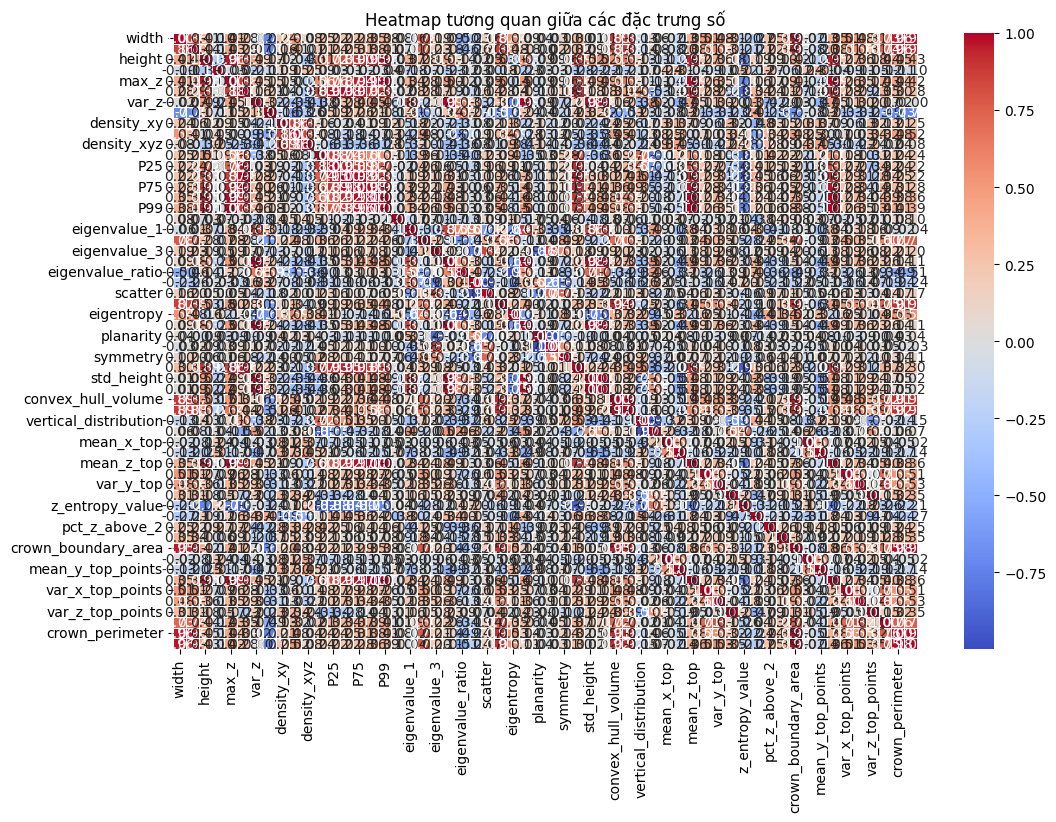

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lọc ra các cột có kiểu dữ liệu số từ full
numeric_df = full.select_dtypes(include=['number'])

# Tính ma trận tương quan
corr_matrix = numeric_df.corr()

# Vẽ heatmap để trực quan hóa mức độ tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap tương quan giữa các đặc trưng số")
plt.show()

In [76]:
full["top_points"]

0      [[545729.53, 6449119.81, 21.54], [545729.48, 6...
1      [[547085.78, 6450425.7, 24.04], [547086.67, 64...
2      [[547106.62, 6450405.66, 23.330000000000002], ...
3      [[547102.88, 6450403.84, 23.1], [547103.76, 64...
4      [[547094.35, 6450403.24, 22.89], [547094.89, 6...
                             ...                        
292    [[547006.65, 6450005.25, 21.14], [547006.39, 6...
293    [[546636.76, 6450130.1, 23.740000000000002], [...
294    [[546639.31, 6450132.76, 24.01], [546639.23, 6...
295    [[546599.05, 6449177.67, 17.09], [546598.81, 6...
296    [[546587.57, 6449146.5, 19.03], [546587.44, 64...
Name: top_points, Length: 297, dtype: object

In [77]:
full["alpha_shape"]

0      POLYGON ((545731.89 6449120.23, 545728.77 6449...
1      POLYGON ((547087.34 6450428.08, 547087.3 64504...
2      POLYGON ((547106.04 6450406.55, 547107.55 6450...
3      POLYGON ((547101.77 6450401.6, 547100.51 64504...
4      POLYGON ((547089.69 6450402.68, 547089.69 6450...
                             ...                        
292    POLYGON ((547005.25 6450006.9, 547006.77 64500...
293    POLYGON ((546638.98 6450131.52, 546639.13 6450...
294    POLYGON ((546638.4 6450135.12, 546639.94 64501...
295    POLYGON ((546597.74 6449176.97, 546597.62 6449...
296    POLYGON ((546587.84 6449147.05, 546588.44 6449...
Name: alpha_shape, Length: 297, dtype: object

In [78]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   path                   297 non-null    object 
 1   species                297 non-null    object 
 2   width                  297 non-null    float64
 3   depth                  297 non-null    float64
 4   height                 297 non-null    float64
 5   min_z                  297 non-null    float64
 6   max_z                  297 non-null    float64
 7   mean_z                 297 non-null    float64
 8   var_z                  297 non-null    float64
 9   vertical_proportion    297 non-null    float64
 10  density_xy             297 non-null    float64
 11  density_yz             297 non-null    float64
 12  density_xyz            297 non-null    float64
 13  P10                    297 non-null    float64
 14  P25                    297 non-null    float64
 15  P50   

In [79]:
species_mapping = {
    "Fir": 0,      # Cây lãnh sam
    "Pine": 1,     # Cây thông
    "Spruce": 2,   # Cây vân sam
    "Alder": 3,    # Cây trăn
    "Aspen": 4,    # Cây dương
    "Birch": 5,    # Cây bạch dương
    "Tilia": 6     # Cây đoạn
}

full["species"] = full["species"].map(species_mapping)

In [80]:
unknown_species = full[full["species"].isna()]["species"].unique()
print("Loài chưa ánh xạ:", unknown_species)

Loài chưa ánh xạ: []


In [81]:
X = full.drop(columns=["path", "species"]).copy()
y = full.pop("species")

In [82]:
X.head()

,width,depth,height,min_z,max_z,mean_z,var_z,vertical_proportion,density_xy,density_yz,...,alpha_shape,mean_x_top_points,mean_y_top_points,mean_z_top_points,var_x_top_points,var_y_top_points,var_z_top_points,max_top_distance,crown_perimeter,crown_compactness
0,4.28,5.02,20.66,1.66,22.32,17.002780,21.136214,2.221505,19.082548,3.953209,...,"POLYGON ((545731.89 6449120.23, 545728.77 6449...",545729.870976,6.449120e+06,21.782439,0.432321,0.412987,0.045711,2.846840,14.145683,0.913247
1,1.95,3.31,23.21,1.02,24.23,17.315165,36.169341,4.412548,98.380975,8.265528,...,"POLYGON ((547087.34 6450428.08, 547087.3 64504...",547086.339531,6.450427e+06,23.346250,0.237514,0.427021,0.082889,3.184462,9.014943,0.551922
2,5.15,3.60,22.64,1.03,23.67,19.881849,22.156052,2.587429,38.511327,8.760306,...,"POLYGON ((547106.04 6450406.55, 547107.55 6450...",547106.601250,6.450406e+06,23.421389,0.186486,0.090503,0.007076,1.903786,14.312699,1.021125
3,3.91,3.32,21.57,1.94,23.51,19.521968,17.640864,2.983402,38.748344,7.023923,...,"POLYGON ((547101.77 6450401.6, 547100.51 64504...",547103.072745,6.450404e+06,23.164706,0.192020,0.032954,0.008829,1.830246,11.844278,0.853176
4,6.06,3.97,21.79,1.42,23.21,18.474711,21.419427,2.172483,36.619531,10.184229,...,"POLYGON ((547089.69 6450402.68, 547089.69 6450...",547094.342093,6.450403e+06,22.632326,0.636624,0.220857,0.062860,4.273757,16.505807,1.131326


In [83]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 60 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   width                  297 non-null    float64
 1   depth                  297 non-null    float64
 2   height                 297 non-null    float64
 3   min_z                  297 non-null    float64
 4   max_z                  297 non-null    float64
 5   mean_z                 297 non-null    float64
 6   var_z                  297 non-null    float64
 7   vertical_proportion    297 non-null    float64
 8   density_xy             297 non-null    float64
 9   density_yz             297 non-null    float64
 10  density_xyz            297 non-null    float64
 11  P10                    297 non-null    float64
 12  P25                    297 non-null    float64
 13  P50                    297 non-null    float64
 14  P75                    297 non-null    float64
 15  P95   

In [84]:
y.value_counts()

species
2    71
5    58
4    55
1    53
0    27
3    20
6    13
Name: count, dtype: int64

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=68, shuffle=True)

In [182]:
X_test.head()

,width,depth,height,min_z,max_z,mean_z,var_z,vertical_proportion,density_xy,density_yz,...,alpha_shape,mean_x_top_points,mean_y_top_points,mean_z_top_points,var_x_top_points,var_y_top_points,var_z_top_points,max_top_distance,crown_perimeter,crown_compactness
220,9.04,8.33,28.40,1.180000,29.580000,21.260087,24.774309,1.635003,152.928428,48.678626,...,"POLYGON ((546939.86 6450037.6, 546939.75 64500...",546940.836635,6.450042e+06,27.760765,0.447089,0.954014,0.330161,5.555583,27.015247,1.994122
40,6.00,6.56,22.89,1.070000,23.960000,19.336568,11.072837,1.822452,42.708333,11.194845,...,"POLYGON ((546615.86 6450169.38, 546615.74 6450...",546618.347665,6.450171e+06,22.771916,0.265760,0.341117,0.184722,4.297278,19.478840,1.417330
248,6.20,6.32,19.53,1.020000,20.550000,13.406418,16.833824,1.559904,97.259085,30.875900,...,"POLYGON ((545698.73 6449912.76, 545700.63 6449...",545698.705066,6.449910e+06,18.973045,0.075760,0.181221,0.473645,3.030660,19.871460,1.448497
286,3.14,4.15,25.20,1.570000,26.770000,22.075324,21.772957,3.456790,27.242729,3.394531,...,"POLYGON ((547083.1 6450385, 547083.56 6450383....",547082.399429,6.450384e+06,26.128286,0.226737,0.432673,0.121203,3.029076,11.323133,0.790091
273,3.96,3.46,17.90,1.149999,19.049999,14.966646,6.478557,2.412399,109.914171,24.316208,...,"POLYGON ((617110.6299999523 6786905.769999991,...",617108.192800,6.786905e+06,18.183733,0.091572,0.072281,0.073737,1.796051,11.284981,0.800108


In [188]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np

# ColumnTransformer kết hợp tất cả các bộ trích xuất đặc trưng
feature_extractor = ColumnTransformer([
    ("scale_numeric", StandardScaler(), make_column_selector(dtype_include=np.number)),  # Chuẩn hóa cột số
    ("extract_alpha_shape", AlphaShapeFeatureExtractor(), ["alpha_shape"]),  # Trích xuất alpha_shape
    ("extract_top_points", TopPointsFeatureExtractor(), ["top_points"])  # Trích xuất top_points
])

# Tiền xử lý dữ liệu
X_train_transformed = feature_extractor.fit_transform(X_train)
X_test_transformed = feature_extractor.transform(X_test)

In [191]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Kích thước đầu vào
input_dim = X_train_transformed.shape[1]

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
bottleneck = Dense(32, activation='relu')(encoded)  # Lớp đặc trưng

# Decoder (tái tạo lại đầu vào)
decoded = Dense(64, activation='relu')(bottleneck)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)  # Phải có cùng shape với input

# Mô hình Autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Huấn luyện Autoencoder
autoencoder.fit(X_train_transformed, X_train_transformed, epochs=50, batch_size=16, verbose=1)

# Trích xuất đặc trưng từ bottleneck
feature_extractor = Model(inputs=input_layer, outputs=bottleneck)
X_train_features = feature_extractor.predict(X_train_transformed)
X_test_features = feature_extractor.predict(X_test_transformed)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9649
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8317 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6524 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4761 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3730 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3039 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2355 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2144 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1982 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1779 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1512 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1465 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1341 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1347 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1285 
Epoch

In [192]:
print(X_train_features)

[[0.0000000e+00 6.5603447e-01 9.5552295e-01 ... 2.3740861e-01
  3.0815501e+00 1.6842856e+00]
 [0.0000000e+00 1.6621828e+00 3.1634673e-01 ... 1.4100095e+00
  1.7907308e+00 1.9118830e+00]
 [5.1447403e-01 1.7509954e+00 5.8942896e-01 ... 2.4324395e-03
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 2.2326133e+00 0.0000000e+00 ... 3.0458763e+00
  0.0000000e+00 1.2453536e+00]
 [0.0000000e+00 2.2831531e+00 4.0969542e-01 ... 1.1352155e+00
  2.8174636e-01 6.9236314e-01]
 [3.1211495e-01 5.6801587e-01 1.0416636e+00 ... 2.4786994e+00
  0.0000000e+00 5.3209567e-01]]


# Multiclass

In [87]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

Thay vì đó ta tiến hành gọi một lớp trích xuất đặc trưng dữ liệu số, sau đó là đến alpha-shape: lưu trữ hình dạng của cây, trích xuất từ top_points: điểm đỉnh

In [181]:
X_train['top_points']

59     [[620209.2500001144, 6787607.9200001145, 20.91...
280    [[620298.5499999523, 6787667.980000128, 23.179...
185    [[457284.2300018311, 6436123.570000763, 21.920...
177    [[457469.55, 6500014.79, 25.89], [457469.17, 6...
51     [[617180.9299998379, 6786950.39, 14.7400009155...
                             ...                        
24     [[547082.86, 6450408.46, 25.26], [547083.67, 6...
156    [[545751.53, 6449851.21, 23.27], [545751.68, 6...
240    [[546012.19, 6449583.23, 23.76], [546011.17999...
236    [[546001.63, 6449550.97, 20.36], [546002.06, 6...
202    [[457277.6999978638, 6436263.990000611, 21.909...
Name: top_points, Length: 178, dtype: object

In [89]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
import numpy as np
from xgboost import XGBClassifier

In [90]:
# Transformer trích xuất diện tích từ alpha_shape
class AlphaShapeFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([
            [(4 * np.pi * shape.area / (shape.length ** 2)) if shape is not None and shape.length > 0 else 0]
            for shape in X["alpha_shape"]
        ])

# Transformer trích xuất trung bình độ cao từ top_pointsgì đó 
class TopPointsFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([
            [np.mean([p[2] for p in points])] if isinstance(points, list) and len(points) > 0 else [0]
            for points in X["top_points"]
        ])
        
class TreeClusterFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cluster_features = []
        
        for clusters in X["point_cloud"]:  # Duyệt từng bộ dữ liệu
            unique_clusters, counts = np.unique(clusters, return_counts=True)  
            
            num_clusters = len(unique_clusters)  # Số cụm
            max_cluster_size = np.max(counts) if len(counts) > 0 else 0  # Cụm lớn nhất
            mean_cluster_size = np.mean(counts) if len(counts) > 0 else 0  # Trung bình
            min_max_ratio = np.min(counts) / np.max(counts) if len(counts) > 1 else 1  # Tỉ lệ cụm nhỏ nhất/lớn nhất
            std_cluster_size = np.std(counts) if len(counts) > 1 else 0  # Độ lệch chuẩn
            median_cluster_size = np.median(counts) if len(counts) > 0 else 0  # Trung vị cụm
            pct_25 = np.percentile(counts, 25) if len(counts) > 0 else 0  # Phân vị 25%
            pct_75 = np.percentile(counts, 75) if len(counts) > 0 else 0  # Phân vị 75%
            max_ratio = max_cluster_size / sum(counts) if sum(counts) > 0 else 0  # Tỷ lệ điểm trong cụm lớn nhất
            
            cluster_features.append([
                num_clusters, max_cluster_size, mean_cluster_size, min_max_ratio,
                std_cluster_size, median_cluster_size, pct_25, pct_75, max_ratio
            ])
        
        return np.array(cluster_features)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.base import BaseEstimator, TransformerMixin

class AutoencoderFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder):
        self.autoencoder = autoencoder
        self.feature_extractor = Model(
            inputs=autoencoder.input, 
            outputs=autoencoder.layers[-4].output  # Lấy output từ lớp bottleneck
        )

    def fit(self, X, y=None):
        return self  # Autoencoder đã huấn luyện trước, không cần fit lại

    def transform(self, X):
        return self.feature_extractor.predict(X)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Kích thước đầu vào
input_dim = X_train_transformed.shape[1]

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
bottleneck = Dense(32, activation='relu')(encoded)  # Lớp đặc trưng

# Decoder (tái tạo lại đầu vào)
decoded = Dense(64, activation='relu')(bottleneck)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)  # Đảm bảo shape khớp với input

# Mô hình Autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Huấn luyện Autoencoder
autoencoder.fit(X_train_transformed, X_train_transformed, epochs=50, batch_size=16, verbose=1)

# Trích xuất đặc trưng từ bottleneck
feature_extractor = AutoencoderFeatureExtractor(autoencoder)

In [ ]:
# ColumnTransformer xử lý tất cả cột số + trích xuất đặc trưng từ object
feature_extractor = ColumnTransformer([
    ("scale_numeric", StandardScaler(), make_column_selector(dtype_include=np.number)),  # Chuẩn hóa tất cả cột số
    # ("extract_alpha_shape", AlphaShapeFeatureExtractor(), ["alpha_shape"]),  # Trích xuất từ alpha_shape
    # ("extract_top_points", TopPointsFeatureExtractor(), ["top_points"])  # Trích xuất từ top_points
])

# Pipeline với Logistic Regression
pipe_lr = Pipeline([
    ("feature_extraction", feature_extractor),
    ("classifier", LogisticRegression(max_iter=10000, 
                                      multi_class="multinomial", 
                                      class_weight="balanced"))
])

In [194]:
# ColumnTransformer xử lý tất cả cột số + trích xuất đặc trưng từ object
feature_extractor = ColumnTransformer([
    ("scale_numeric", StandardScaler(), make_column_selector(dtype_include=np.number)),  # Chuẩn hóa tất cả cột số
    # ("extract_alpha_shape", AlphaShapeFeatureExtractor(), ["alpha_shape"]),  # Trích xuất từ alpha_shape
    # ("extract_top_points", TopPointsFeatureExtractor(), ["top_points"]),  # Trích xuất từ top_points
    # ("extract_tree_clusters", TreeClusterFeatureExtractor(), ["point_cloud"])  # Đặc trưng từ phân cụm
])

# Pipeline với Logistic Regression
pipe_rf = Pipeline([
    ("feature_extraction", feature_extractor),
    ("classifier", RandomForestClassifier(
                            n_estimators=500,
                           class_weight="balanced", 
                           random_state=42))
])

In [195]:
# Tạo pipeline với XGBoost
pipe_xgb = Pipeline([
    ("feature_extraction", ColumnTransformer([
        ("scale_numeric", StandardScaler(), make_column_selector(dtype_include=np.number)),
        # ("extract_alpha_shape", AlphaShapeFeatureExtractor(), ["alpha_shape"]),
        # ("extract_top_points", TopPointsFeatureExtractor(), ["top_points"])
    ])),
    ("classifier", XGBClassifier(
        objective="multi:softmax",
        num_class=7,  # Số lớp (1-7)
        n_estimators=500,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1.5,
        random_state=42
    ))
])

CPU times: user 1.39 s, sys: 15.5 ms, total: 1.4 s
Wall time: 817 ms


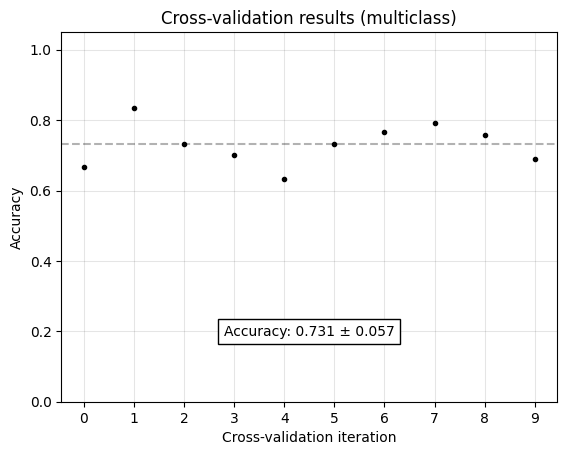

In [94]:
%%time
# Cái này là giá của luồng pipe_lr
cv_result_multi = cross_validate(
    estimator=pipe_lr,
    X=X,
    y=y,
    cv=10,
    scoring="accuracy",
)

scores = cv_result_multi["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (multiclass)")
ax.grid(color="k", alpha=0.1)

CPU times: user 12.4 s, sys: 86.6 ms, total: 12.5 s
Wall time: 12.3 s


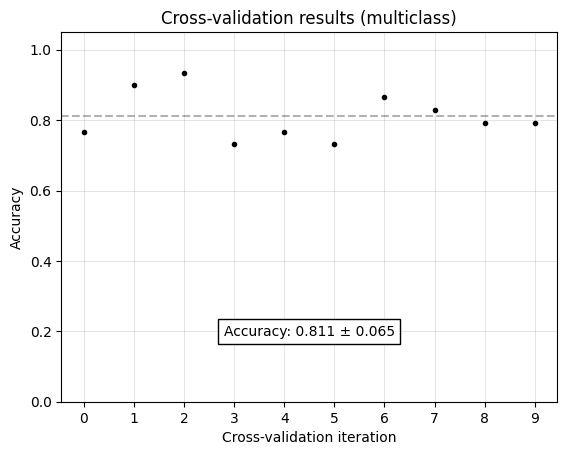

In [95]:
%%time
# Cái này là giá của luồng pipe_rf
cv_result_multi = cross_validate(
    estimator=pipe_rf,
    X=X,
    y=y,
    cv=10,
    scoring="accuracy",
)

scores = cv_result_multi["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (multiclass)")
ax.grid(color="k", alpha=0.1)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:38:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:38:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:38:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:38:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:38:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weigh

CPU times: user 1min 38s, sys: 1.47 s, total: 1min 39s
Wall time: 26.5 s


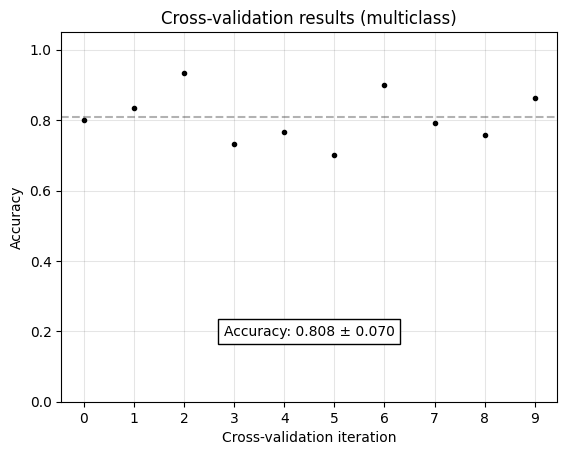

In [96]:
%%time

cv_result_multi = cross_validate(
    estimator=pipe_xgb,
    X=X,
    y=y,
    cv=10,
    scoring="accuracy",
)

scores = cv_result_multi["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (multiclass)")
ax.grid(color="k", alpha=0.1)

In [196]:
# Huấn luyện pipeline
pipe_lr.fit(X_train_features, y_train)
pipe_rf.fit(X_train_features, y_train)
pipe_xgb.fit(X_train_features, y_train)

ValueError: make_column_selector can only be applied to pandas dataframes

In [98]:
pred_multi_lr = pipe_lr.predict(X_test)
pred_multi_rf = pipe_rf.predict(X_test)
pred_multi_xgb = pipe_xgb.predict(X_test)

Accuracy: 0.7143
              precision    recall  f1-score   support

           0     0.5455    0.7500    0.6316         8
           1     0.9444    0.8947    0.9189        19
           2     0.9259    0.7812    0.8475        32
           3     0.5385    0.7778    0.6364         9
           4     0.5200    0.7647    0.6190        17
           5     0.6818    0.6250    0.6522        24
           6     0.6667    0.2000    0.3077        10

    accuracy                         0.7143       119
   macro avg     0.6890    0.6848    0.6590       119
weighted avg     0.7450    0.7143    0.7110       119



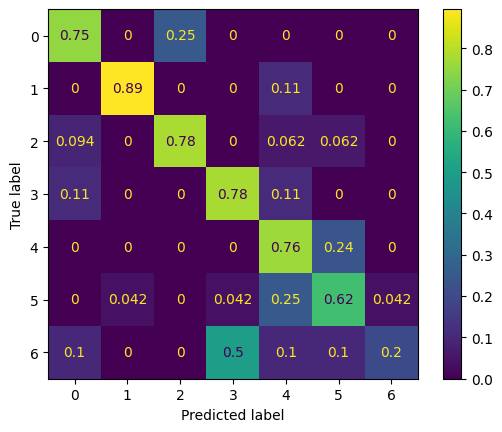

In [99]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Tính Accuracy
accuracy = accuracy_score(y_test, pred_multi_lr)
print(f"Accuracy: {accuracy:.4f}")

# In báo cáo chi tiết Precision, Recall, F1-score
print(classification_report(y_test, pred_multi_lr, digits=4))

# Vẽ ma trận nhầm lẫn (Confusion Matrix)
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=pred_multi_lr,
    normalize="true",  # Bình thường hóa theo hàng (giá trị từ 0 -> 1)
)


Accuracy: 0.8067
              precision    recall  f1-score   support

           0     0.5000    0.5000    0.5000         8
           1     0.9500    1.0000    0.9744        19
           2     0.8824    0.9375    0.9091        32
           3     0.5556    0.5556    0.5556         9
           4     0.6957    0.9412    0.8000        17
           5     0.8750    0.8750    0.8750        24
           6     1.0000    0.1000    0.1818        10

    accuracy                         0.8067       119
   macro avg     0.7798    0.7013    0.6851       119
weighted avg     0.8245    0.8067    0.7817       119



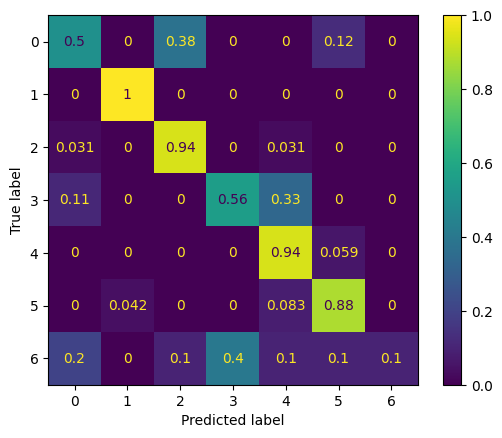

In [100]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Tính Accuracy
accuracy = accuracy_score(y_test, pred_multi_rf)
print(f"Accuracy: {accuracy:.4f}")

# In báo cáo chi tiết Precision, Recall, F1-score
print(classification_report(y_test, pred_multi_rf, digits=4))

# Vẽ ma trận nhầm lẫn (Confusion Matrix)
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=pred_multi_rf,
    normalize="true",  # Bình thường hóa theo hàng (giá trị từ 0 -> 1)
)


Accuracy: 0.8487
              precision    recall  f1-score   support

           0     0.6667    0.7500    0.7059         8
           1     1.0000    1.0000    1.0000        19
           2     0.9677    0.9375    0.9524        32
           3     0.5833    0.7778    0.6667         9
           4     0.7273    0.9412    0.8205        17
           5     0.8750    0.8750    0.8750        24
           6     1.0000    0.2000    0.3333        10

    accuracy                         0.8487       119
   macro avg     0.8314    0.7831    0.7648       119
weighted avg     0.8732    0.8487    0.8353       119



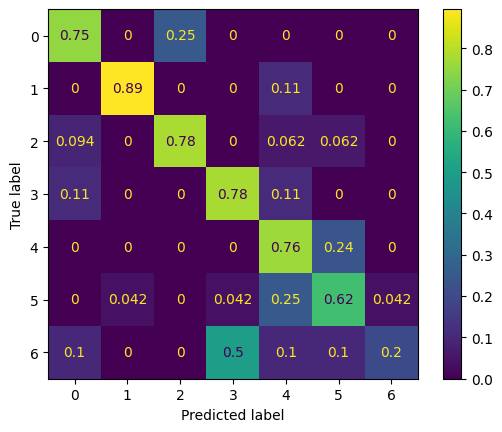

In [101]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Tính Accuracy
accuracy = accuracy_score(y_test, pred_multi_xgb)
print(f"Accuracy: {accuracy:.4f}")

# In báo cáo chi tiết Precision, Recall, F1-score
print(classification_report(y_test, pred_multi_xgb, digits=4))

# Vẽ ma trận nhầm lẫn (Confusion Matrix)
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=pred_multi_lr,
    normalize="true",  # Bình thường hóa theo hàng (giá trị từ 0 -> 1)
)

In [159]:
# Kết hợp 2 mô hình bằng VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('lr', pipe_lr),
    ('rf', pipe_rf),
    ('xgb', pipe_xgb)
], voting='soft')  # 'soft' dùng xác suất dự đoán, 'hard' chỉ lấy kết quả đa số

# Train mô hình
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:50:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('feature_extraction',
                                               ColumnTransformer(transformers=[('scale_numeric',
                                                                                StandardScaler(),
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x7ecf95f16c50>),
                                                                               ('extract_alpha_shape',
                                                                                AlphaShapeFeatureExtractor(),
                                                                                ['alpha_shape']),
                                                                               ('extract_top_points',
                                                                                TopPointsFeatureExtractor(),
                                                                                ['top_poin...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=10,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_class=7,
                                                             num_parallel_tree=None, ...))]))],
                 voting='soft')

# Testing

In [115]:
test_file_paths = glob.glob("/kaggle/input/hutechaichallenge2024-mc/Test/*/*.las")
test_file_paths.sort()

In [116]:
test_data = pd.DataFrame({"path": test_file_paths})
test_data["species"] = test_data["path"].map(lambda p: p.split("/")[-2])
test_data.sample(n=3)

,path,species
61,/kaggle/input/hutechaichallenge2024-mc/Test/Pi...,Pine
78,/kaggle/input/hutechaichallenge2024-mc/Test/Sp...,Spruce
79,/kaggle/input/hutechaichallenge2024-mc/Test/Sp...,Spruce


In [117]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   path     97 non-null     object
 1   species  97 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


In [118]:
features_test = pd.json_normalize(test_data["path"].map(compute_cloud_features))
full_test = pd.concat([test_data, features_test], axis=1)

In [119]:
full_test["mean_x_top_points"] = full_test["top_points"].apply(lambda pts: np.mean([p[0] for p in pts]))
full_test["mean_y_top_points"] = full_test["top_points"].apply(lambda pts: np.mean([p[1] for p in pts]))
full_test["mean_z_top_points"] = full_test["top_points"].apply(lambda pts: np.mean([p[2] for p in pts]))

full_test["var_x_top_points"] = full_test["top_points"].apply(lambda pts: np.var([p[0] for p in pts]))
full_test["var_y_top_points"] = full_test["top_points"].apply(lambda pts: np.var([p[1] for p in pts]))
full_test["var_z_top_points"] = full_test["top_points"].apply(lambda pts: np.var([p[2] for p in pts]))

from scipy.spatial.distance import pdist
full_test["max_top_distance"] = full_test["top_points"].apply(lambda pts: np.max(pdist(pts[:, :2])) if len(pts) > 1 else 0)

full_test["crown_boundary_area"] = full_test["alpha_shape"].apply(lambda poly: poly.area)
full_test["crown_perimeter"] = full_test["alpha_shape"].apply(lambda poly: poly.length)
full_test["crown_compactness"] = full_test["crown_boundary_area"] / full_test["crown_perimeter"]

In [120]:
full_test.head()

,path,species,width,depth,height,min_z,max_z,mean_z,var_z,vertical_proportion,...,alpha_shape,mean_x_top_points,mean_y_top_points,mean_z_top_points,var_x_top_points,var_y_top_points,var_z_top_points,max_top_distance,crown_perimeter,crown_compactness
0,/kaggle/input/hutechaichallenge2024-mc/Test/Al...,Alder,3.02,2.79,21.78,1.05,22.83,18.360864,26.058817,3.748709,...,"POLYGON ((546642.59 6450148.83, 546643.03 6450...",546644.341719,6.450148e+06,22.382812,0.053320,0.048702,0.027967,1.145295,9.485367,0.680237
1,/kaggle/input/hutechaichallenge2024-mc/Test/Al...,Alder,4.38,2.80,20.54,1.04,21.58,16.403645,22.546206,2.860724,...,"POLYGON ((546641.81 6450144.41, 546641.09 6450...",546642.698507,6.450146e+06,20.951045,0.051287,0.079273,0.044669,1.652059,11.682596,0.790312
2,/kaggle/input/hutechaichallenge2024-mc/Test/Al...,Alder,4.24,3.53,21.63,1.03,22.66,16.711168,28.161137,2.783784,...,"POLYGON ((546635.64 6450140.03, 546635.82 6450...",546636.244717,6.450138e+06,22.123019,0.120382,0.129930,0.083398,1.968248,11.758223,0.815004
3,/kaggle/input/hutechaichallenge2024-mc/Test/Al...,Alder,2.46,3.25,15.37,4.83,20.20,16.601674,14.275787,2.691769,...,"POLYGON ((545715 6449888.17, 545713.31 6449889...",545714.764091,6.449890e+06,19.816818,0.039033,0.042551,0.050667,0.906091,8.610399,0.566397
4,/kaggle/input/hutechaichallenge2024-mc/Test/Al...,Alder,2.93,4.58,12.77,5.45,18.22,14.581734,7.531544,1.700399,...,"POLYGON ((545715.77 6449917.96, 545717.38 6449...",545716.696486,6.449915e+06,17.896216,0.093980,0.057711,0.016959,1.119866,12.420625,0.829934


In [121]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   path                   97 non-null     object 
 1   species                97 non-null     object 
 2   width                  97 non-null     float64
 3   depth                  97 non-null     float64
 4   height                 97 non-null     float64
 5   min_z                  97 non-null     float64
 6   max_z                  97 non-null     float64
 7   mean_z                 97 non-null     float64
 8   var_z                  97 non-null     float64
 9   vertical_proportion    97 non-null     float64
 10  density_xy             97 non-null     float64
 11  density_yz             97 non-null     float64
 12  density_xyz            97 non-null     float64
 13  P10                    97 non-null     float64
 14  P25                    97 non-null     float64
 15  P50     

In [122]:
# Lấy ngẫu nhiên 1 mẫu từ mỗi species
sampled_data_test = full_test.groupby("species").sample(n=1, random_state=42)

# Hiển thị kết quả
sampled_data_test

,path,species,width,depth,height,min_z,max_z,mean_z,var_z,vertical_proportion,...,alpha_shape,mean_x_top_points,mean_y_top_points,mean_z_top_points,var_x_top_points,var_y_top_points,var_z_top_points,max_top_distance,crown_perimeter,crown_compactness
0,/kaggle/input/hutechaichallenge2024-mc/Test/Al...,Alder,3.02,2.79,21.78,1.05,22.83,18.360864,26.058817,3.748709,...,"POLYGON ((546642.59 6450148.83, 546643.03 6450...",546644.341719,6.450148e+06,22.382812,0.053320,0.048702,0.027967,1.145295,9.485367,0.680237
21,/kaggle/input/hutechaichallenge2024-mc/Test/As...,Aspen,5.20,4.66,21.07,1.02,22.09,18.568776,5.597115,2.136917,...,"POLYGON ((620296.1200002098 6787610.889999541,...",620297.191167,6.787610e+06,21.363634,0.106266,0.054699,0.092761,2.001250,15.469515,1.080503
25,/kaggle/input/hutechaichallenge2024-mc/Test/Bi...,Birch,6.05,7.35,21.05,1.49,22.54,18.041111,7.513544,1.570896,...,"POLYGON ((453235.2300012398 6628712.639990283,...",453237.106390,6.628710e+06,22.199944,0.158008,0.138077,0.042694,2.099905,20.103106,1.443680
48,/kaggle/input/hutechaichallenge2024-mc/Test/Fi...,Fir,4.25,3.68,26.41,1.59,28.00,17.543919,26.394726,3.330391,...,"POLYGON ((546221.3 6449184.74, 546221.09 64491...",546219.728018,6.449187e+06,25.603243,0.044064,0.049998,0.906627,1.655174,12.619759,0.915675
63,/kaggle/input/hutechaichallenge2024-mc/Test/Pi...,Pine,3.17,2.87,23.35,1.37,24.72,22.221022,9.409045,3.865894,...,"POLYGON ((457314.19999908446 6436308.46999817,...",457315.742531,6.436309e+06,24.267722,0.064718,0.182047,0.036076,1.867244,8.815971,0.595255
72,/kaggle/input/hutechaichallenge2024-mc/Test/Sp...,Spruce,4.16,4.38,18.10,1.45,19.55,14.953715,4.930606,2.119438,...,"POLYGON ((620213.8100002288 6787593.159999829,...",620213.075152,6.787591e+06,18.561061,0.080928,0.040101,0.184169,1.534047,13.383435,0.980981
94,/kaggle/input/hutechaichallenge2024-mc/Test/Ti...,Tilia,2.20,2.27,15.69,2.36,18.05,15.743063,4.965128,3.510067,...,"POLYGON ((546609.27 6449150.76, 546610.5 64491...",546610.136071,6.449150e+06,17.803571,0.012881,0.289089,0.012330,1.412834,7.419545,0.506689


In [123]:
species_mapping_test = {
    "Fir": 1,      # Cây lãnh sam
    "Pine": 2,     # Cây thông
    "Spruce": 3,   # Cây vân sam
    "Alder": 4,    # Cây trăn
    "Aspen": 5,    # Cây dương
    "Birch": 6,    # Cây bạch dương
    "Tilia": 7     # Cây đoạn
}

In [124]:
full_test["species"] = full_test["species"].map(species_mapping_test)

In [125]:
unknown_species_test = full_test[full_test["species"].isna()]["species"].unique()
print("Loài chưa ánh xạ:", unknown_species_test)

Loài chưa ánh xạ: []


In [126]:
X_test_test = full_test.drop(columns=["path", "species"]).copy()

In [127]:
X_test_test.head()

,width,depth,height,min_z,max_z,mean_z,var_z,vertical_proportion,density_xy,density_yz,...,alpha_shape,mean_x_top_points,mean_y_top_points,mean_z_top_points,var_x_top_points,var_y_top_points,var_z_top_points,max_top_distance,crown_perimeter,crown_compactness
0,3.02,2.79,21.78,1.05,22.83,18.360864,26.058817,3.748709,76.906644,10.663823,...,"POLYGON ((546642.59 6450148.83, 546643.03 6450...",546644.341719,6.450148e+06,22.382812,0.053320,0.048702,0.027967,1.145295,9.485367,0.680237
1,4.38,2.80,20.54,1.04,21.58,16.403645,22.546206,2.860724,54.142205,11.545417,...,"POLYGON ((546641.81 6450144.41, 546641.09 6450...",546642.698507,6.450146e+06,20.951045,0.051287,0.079273,0.044669,1.652059,11.682596,0.790312
2,4.24,3.53,21.63,1.03,22.66,16.711168,28.161137,2.783784,70.353840,13.791044,...,"POLYGON ((546635.64 6450140.03, 546635.82 6450...",546636.244717,6.450138e+06,22.123019,0.120382,0.129930,0.083398,1.968248,11.758223,0.815004
3,2.46,3.25,15.37,4.83,20.20,16.601674,14.275787,2.691769,26.891807,4.304089,...,"POLYGON ((545715 6449888.17, 545713.31 6449889...",545714.764091,6.449890e+06,19.816818,0.039033,0.042551,0.050667,0.906091,8.610399,0.566397
4,2.93,4.58,12.77,5.45,18.22,14.581734,7.531544,1.700399,29.658554,6.804978,...,"POLYGON ((545715.77 6449917.96, 545717.38 6449...",545716.696486,6.449915e+06,17.896216,0.093980,0.057711,0.016959,1.119866,12.420625,0.829934


In [167]:
pred_multi_test = pipe_xgb.predict(X_test_test)

In [168]:
y_test_true = full_test["species"].values

In [169]:
print(y_test_true)

[4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7 7 7 7]


In [170]:
print(pred_multi_test + 1)

[4 4 4 6 4 4 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 6 6 5 6 6 6 6 5 5 5 5 5 5
 5 5 6 5 5 5 1 1 1 1 3 3 1 3 1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 5
 3 5 3 3 5 3 3 5 5 5 5 3 3 3 3 3 3 3 3 4 4 4 7]


Accuracy: 0.7113
              precision    recall  f1-score   support

           1     1.0000    0.6000    0.7500        10
           2     1.0000    1.0000    1.0000        17
           3     0.7619    0.6957    0.7273        23
           4     0.6250    0.8333    0.7143         6
           5     0.4722    0.9444    0.6296        18
           6     0.8750    0.3684    0.5185        19
           7     1.0000    0.2500    0.4000         4

    accuracy                         0.7113        97
   macro avg     0.8192    0.6703    0.6771        97
weighted avg     0.7979    0.7113    0.7041        97



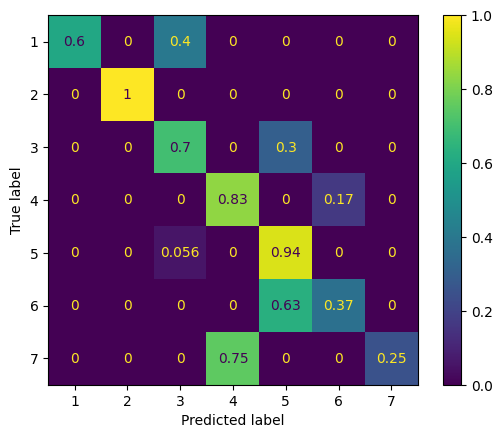

In [171]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Tính Accuracy
accuracy = accuracy_score(y_test_true, pred_multi_test + 1)
print(f"Accuracy: {accuracy:.4f}")

# In báo cáo chi tiết Precision, Recall, F1-score
print(classification_report(y_test_true, pred_multi_test + 1, digits=4))

# Vẽ ma trận nhầm lẫn (Confusion Matrix)
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test_true,
    y_pred=pred_multi_test + 1,
    normalize="true",  # Bình thường hóa theo hàng (giá trị từ 0 -> 1)
)

In [172]:
import os
# Lấy tên file từ cột "path", bỏ phần mở rộng .las
file_names = full_test["path"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# Tạo DataFrame submission
submission = pd.DataFrame({
    "name": file_names,
    "label": pred_multi_test + 1
})

# Lưu file CSV
submission.to_csv("submission.csv", index=False)

print("File submission.csv đã được tạo thành công!")

File submission.csv đã được tạo thành công!


In [166]:
df_sub = pd.read_csv("/kaggle/working/submission.csv")
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    97 non-null     object
 1   label   97 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
